# Image Classification with Deep Learning

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)
%matplotlib inline

## Reading the data

In [2]:
# Create data generators with rescaling 
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/train/', target_size=(64, 64), batch_size=5216)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/test/', target_size=(64, 64), batch_size=624)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/val/', target_size=(64, 64))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [3]:
# Retrieve a batch of training images and their corresponding labels
train_images, train_labels = next(train_generator)

# Retrieve a batch of test images and their corresponding labels
test_images, test_labels = next(test_generator)

# Retrieve a batch of validation images and their corresponding labels
val_images, val_labels = next(val_generator)

In [4]:
# Checking the shape of the train_images and train_labels
train_images.shape, train_labels.shape

((5216, 64, 64, 3), (5216, 2))

In [5]:
# Checking the shape of the test_images and test_labels
test_images.shape, test_labels.shape

((624, 64, 64, 3), (624, 2))

In [6]:
# Checking the shape of the val_images and val_labels
val_images.shape, val_labels.shape

((16, 64, 64, 3), (16, 2))

The label's shape indicates that this is a binary classification problem. The labels suggest that the images can only represent two classes: "normal" or "pneumonia," which implies that the goal is to determine whether a patient has pneumonia or not.

## Modeling the Data

### Using Dense layers

In [7]:
# Flattening the train set to all for modeling
train_reshaped = train_images.reshape(5216, 64*64*3)

# Flattening the test set to all for modeling
test_reshape = test_images.reshape(624, 64*64*3)

# Flattening the validation set to all for modeling
val_reshape = val_images.reshape(16, 64*64*3)

In [8]:
# initialized the model
dense_model = Sequential()

# Input Layer
dense_model.add(Dense(64, activation='relu', input_shape=(64*64*3,)))
# Hidden Layer
dense_model.add(Dense(64, activation="relu"))
dense_model.add(Dense(32, activation="LeakyReLU"))
# Output Layer
dense_model.add(Dense(2, activation="softmax"))

dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                786496    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 792802 (3.02 MB)
Trainable params: 792802 (3.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Compile the dense neural network model
dense_model.compile(
    optimizer="adam",
    loss= "binary_crossentropy",
    metrics=['accuracy']
)

In [10]:
# Creating a EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='min')

# Defining the path for saving checkpoints
checkpoint_filepath = 'dense_model.h5'

# Create a ModelCheckpoint callback to save the best model weights
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',  
    save_best_only=True, 
    mode='min',  
    verbose=1  
)

In [11]:
history = dense_model.fit(
    train_reshaped,
    train_labels,
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint],
    validation_data=(val_reshape, val_labels),
    batch_size=32
)

Epoch 1/1000
163/163 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8671
Epoch 1: val_loss improved from inf to 0.61421, saving model to dense_model.h5
163/163 [==============================] - 9s 47ms/step - loss: 0.3121 - accuracy: 0.8671 - val_loss: 0.6142 - val_accuracy: 0.6875
Epoch 2/1000
163/163 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9356
Epoch 2: val_loss improved from 0.61421 to 0.25029, saving model to dense_model.h5
163/163 [==============================] - 5s 28ms/step - loss: 0.1746 - accuracy: 0.9356 - val_loss: 0.2503 - val_accuracy: 0.9375
Epoch 3/1000
163/163 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9369
Epoch 3: val_loss improved from 0.25029 to 0.23300, saving model to dense_model.h5
163/163 [==============================] - 6s 36ms/step - loss: 0.1598 - accuracy: 0.9369 - val_loss: 0.2330 - val_accuracy: 0.9375
Epoch 4/1000
161/163 [============================>.] - ETA: 0s -

In [12]:
def plot_loss(model):
    # Extract training and validation loss values from the model's history
    training_loss = model.history['loss']
    validation_loss = model.history['val_loss']

    # Plot the training loss and validation loss
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(training_loss, label='Training Loss')
    ax.plot(validation_loss, label='Validation Loss')

    # Adding titles and labels to the plot
    ax.set_title('Training and Validation Loss Curves') 
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    # Add a grid to the plot for better visualization
    ax.grid()

    # Add a legend to distinguish between training and validation loss
    ax.legend()
    plt.show()

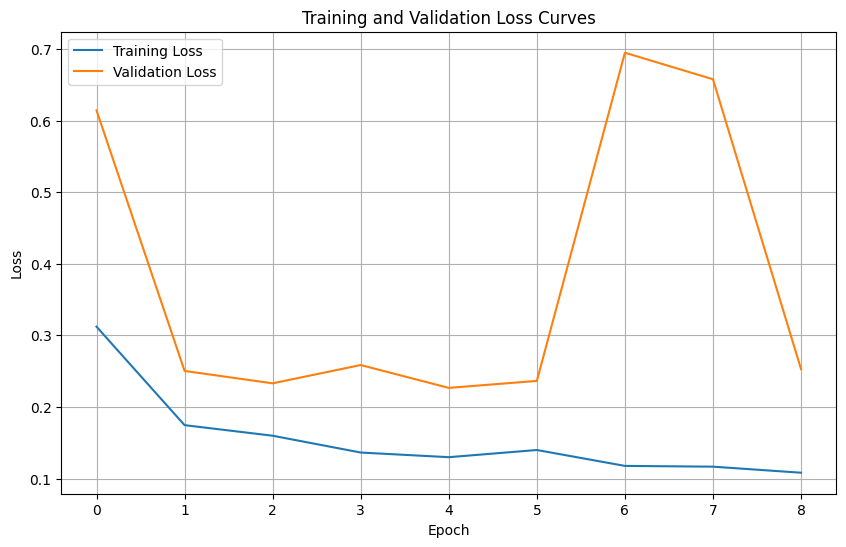

In [13]:
# Plotting the dense model
plot_loss(history)

Based on the graph shown above, it's evident that the model performs well on the training data, as indicated by the consistently low loss function, mostly below 0.2, as the number of epochs increases. Meanwhile, the validation set, which serves the purpose of preventing overfitting, demonstrates its lowest loss at 5 epochs, where it reaches a value of 0.22661. Notably, the model weights at this point have been saved in a file named "dense_model.h5."

### Evaluating the dense model

In [14]:
# Load the saved model weights
dense_model.load_weights("dense_model.h5")

# Evaluate the model on the test data
test_loss, test_accuracy = dense_model.evaluate(test_reshape, test_labels, batch_size=39)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 0s 5ms/step - loss: 0.5676 - accuracy: 0.7933
Test Loss: 0.5676397681236267
Test Accuracy: 0.7932692170143127


When evaluating the model, it demonstrates significant performance with an accuracy of 0.7933, indicating that it is performing well.

### Using CNNs

In [15]:
# Initialized the cnn model
cnn_model = Sequential()

# Input Layer
cnn_model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape = (64, 64, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(2))

# Hidden Layer
cnn_model.add(Conv2D(64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPool2D(2))

cnn_model.add(Conv2D(32, kernel_size=3, activation='LeakyReLU'))
cnn_model.add(MaxPool2D(2))
cnn_model.add(Flatten())
# Output Layer
cnn_model.add(Dense(2, activation='softmax'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                      

In [16]:
# Compile the CNNs model
cnn_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ['accuracy']
)

# Defining the path for saving checkpoints
cnn_filepath = "cnn_model.h5"

# Create a ModelCheckpoint callback to save the best model weights
cnn_modelcheckpoint = ModelCheckpoint(
    cnn_filepath,
    monitor='val_loss',  
    save_best_only=True, 
    mode='min',  
    verbose=1 
)

In [17]:
cnn_history = cnn_model.fit(
    train_images,
    train_labels,
    epochs=1000,
    callbacks=[early_stopping, cnn_modelcheckpoint],
    validation_data=(val_images, val_labels),
    batch_size=32
)

Epoch 1/1000
163/163 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9308
Epoch 1: val_loss improved from inf to 0.63678, saving model to cnn_model.h5
163/163 [==============================] - 78s 475ms/step - loss: 0.1717 - accuracy: 0.9308 - val_loss: 0.6368 - val_accuracy: 0.6250
Epoch 2/1000
163/163 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9718
Epoch 2: val_loss did not improve from 0.63678
163/163 [==============================] - 90s 554ms/step - loss: 0.0825 - accuracy: 0.9718 - val_loss: 0.6983 - val_accuracy: 0.5625
Epoch 3/1000
163/163 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9789
Epoch 3: val_loss improved from 0.63678 to 0.24224, saving model to cnn_model.h5
163/163 [==============================] - 100s 609ms/step - loss: 0.0597 - accuracy: 0.9789 - val_loss: 0.2422 - val_accuracy: 1.0000
Epoch 4/1000
163/163 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9833


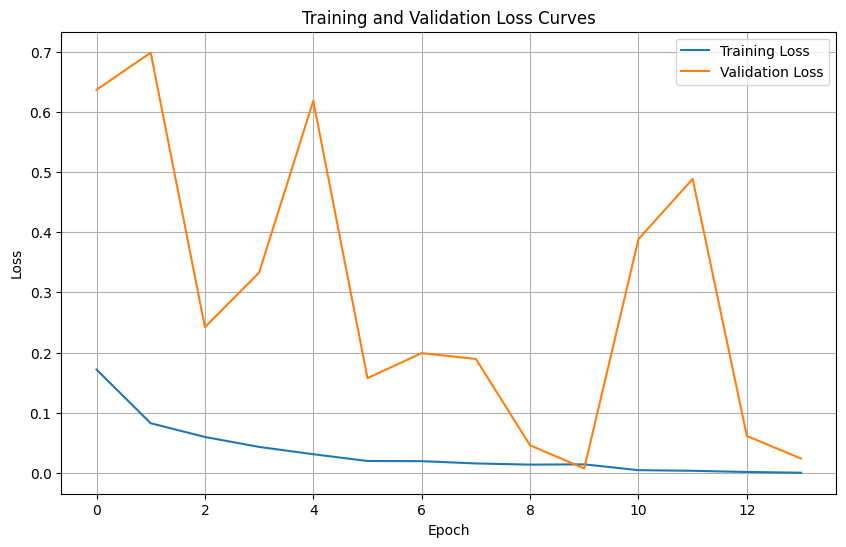

In [18]:
plot_loss(cnn_history)

Based on the graph above, the performance of the CNN model is impressive as it fits the training data well, consistently maintaining a loss below 0.3. In contrast, the validation set, which plays a crucial role in preventing overfitting, achieves its lowest loss at 9 epochs, with a value of 0.00731. The model's weights have been saved in the file "cnn_model.h5."

### Evaluate CNN model

In [19]:
# Load the saved model weights
cnn_model.load_weights('cnn_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels, batch_size=39)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 2s 99ms/step - loss: 1.1642 - accuracy: 0.8093
Test Loss: 1.1642184257507324
Test Accuracy: 0.8092948794364929


When evaluating the model, it demonstrates significant performance with an accuracy of 0.8093, indicating that it is performing well.